In [1]:
!pip install basicsr pillow ipython



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Now run this next cell to import all necessary packages:

In [3]:
import cv2
import math
import numpy as np
import os
import queue
import threading
import torch

from torch.nn import functional as F
from torch import nn as nn
from PIL import Image
from basicsr.archs.rrdbnet_arch import RRDBNet
from math import ceil, floor, sqrt
from PIL import Image, ImageFilter
from IPython.display import Image as display_image

## Codes [**Click the play button below to run all the hidden cells. No need to open this tab unless you want to inspect all the long long codes...**]

### Utilities

These are the Utils functions and the classes containing the actual model architecture:

In [4]:
# Utils
# ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

def convert_to_jpg(input_path, output_path):
    # Open the PNG file
    with Image.open(input_path) as img:
        # Save the image in JPEG format
        img.convert("RGB").save(output_path, 'JPEG')


class RealESRGANer():
    """A helper class for upsampling images with RealESRGAN.

    Args:
        scale (int): Upsampling scale factor used in the networks. It is usually 2 or 4.
        model_path (str): The path to the pretrained model. It can be urls (will first download it automatically).
        model (nn.Module): The defined network. Default: None.
        tile (int): As too large images result in the out of GPU memory issue, so this tile option will first crop
            input images into tiles, and then process each of them. Finally, they will be merged into one image.
            0 denotes for do not use tile. Default: 0.
        tile_pad (int): The pad size for each tile, to remove border artifacts. Default: 10.
        pre_pad (int): Pad the input images to avoid border artifacts. Default: 10.
        half (float): Whether to use half precision during inference. Default: False.
    """

    def __init__(self,
                 scale,
                 model_path,
                 model=None,
                 tile=0,
                 tile_pad=10,
                 pre_pad=10,
                 half=False,
                 device=None,
                 gpu_id=None):
        self.scale = scale
        self.tile_size = tile
        self.tile_pad = tile_pad
        self.pre_pad = pre_pad
        self.mod_scale = None
        self.half = half

        # initialize model
        if gpu_id:
            self.device = torch.device(
                f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu') if device is None else device
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') if device is None else device
        # if the model_path starts with https, it will first download models to the folder: realesrgan/weights
        # if model_path.startswith('https://'):
        #     model_path = load_file_from_url(
        #         url=model_path, model_dir='realesrgan/weights')
        loadnet = torch.load(model_path, map_location=torch.device('cpu'))
        # prefer to use params_ema
        if 'params_ema' in loadnet:
            keyname = 'params_ema'
        else:
            keyname = 'params'
        model.load_state_dict(loadnet[keyname], strict=True)
        model.eval()
        self.model = model.to(self.device)
        if self.half:
            self.model = self.model.half()

    def pre_process(self, img):
        """Pre-process, such as pre-pad and mod pad, so that the images can be divisible
        """
        img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
        self.img = img.unsqueeze(0).to(self.device)
        if self.half:
            self.img = self.img.half()

        # pre_pad
        if self.pre_pad != 0:
            self.img = F.pad(self.img, (0, self.pre_pad, 0, self.pre_pad), 'reflect')
        # mod pad for divisible borders
        if self.scale == 2:
            self.mod_scale = 2
        elif self.scale == 1:
            self.mod_scale = 4
        if self.mod_scale is not None:
            self.mod_pad_h, self.mod_pad_w = 0, 0
            _, _, h, w = self.img.size()
            if (h % self.mod_scale != 0):
                self.mod_pad_h = (self.mod_scale - h % self.mod_scale)
            if (w % self.mod_scale != 0):
                self.mod_pad_w = (self.mod_scale - w % self.mod_scale)
            self.img = F.pad(self.img, (0, self.mod_pad_w, 0, self.mod_pad_h), 'reflect')

    def process(self):
        # model inference
        self.output = self.model(self.img)

    def tile_process(self):
        """It will first crop input images to tiles, and then process each tile.
        Finally, all the processed tiles are merged into one images.

        Modified from: https://github.com/ata4/esrgan-launcher
        """
        batch, channel, height, width = self.img.shape
        output_height = height * self.scale
        output_width = width * self.scale
        output_shape = (batch, channel, output_height, output_width)

        # start with black image
        self.output = self.img.new_zeros(output_shape)
        tiles_x = math.ceil(width / self.tile_size)
        tiles_y = math.ceil(height / self.tile_size)

        # loop over all tiles
        for y in range(tiles_y):
            for x in range(tiles_x):
                # extract tile from input image
                ofs_x = x * self.tile_size
                ofs_y = y * self.tile_size
                # input tile area on total image
                input_start_x = ofs_x
                input_end_x = min(ofs_x + self.tile_size, width)
                input_start_y = ofs_y
                input_end_y = min(ofs_y + self.tile_size, height)

                # input tile area on total image with padding
                input_start_x_pad = max(input_start_x - self.tile_pad, 0)
                input_end_x_pad = min(input_end_x + self.tile_pad, width)
                input_start_y_pad = max(input_start_y - self.tile_pad, 0)
                input_end_y_pad = min(input_end_y + self.tile_pad, height)

                # input tile dimensions
                input_tile_width = input_end_x - input_start_x
                input_tile_height = input_end_y - input_start_y
                tile_idx = y * tiles_x + x + 1
                input_tile = self.img[:, :, input_start_y_pad:input_end_y_pad, input_start_x_pad:input_end_x_pad]

                # upscale tile
                try:
                    with torch.no_grad():
                        output_tile = self.model(input_tile)
                except RuntimeError as error:
                    print('Error', error)
                print(f'\tTile {tile_idx}/{tiles_x * tiles_y}')

                # output tile area on total image
                output_start_x = input_start_x * self.scale
                output_end_x = input_end_x * self.scale
                output_start_y = input_start_y * self.scale
                output_end_y = input_end_y * self.scale

                # output tile area without padding
                output_start_x_tile = (input_start_x - input_start_x_pad) * self.scale
                output_end_x_tile = output_start_x_tile + input_tile_width * self.scale
                output_start_y_tile = (input_start_y - input_start_y_pad) * self.scale
                output_end_y_tile = output_start_y_tile + input_tile_height * self.scale

                # put tile into output image
                self.output[:, :, output_start_y:output_end_y,
                            output_start_x:output_end_x] = output_tile[:, :, output_start_y_tile:output_end_y_tile,
                                                                       output_start_x_tile:output_end_x_tile]

    def post_process(self):
        # remove extra pad
        if self.mod_scale is not None:
            _, _, h, w = self.output.size()
            self.output = self.output[:, :, 0:h - self.mod_pad_h * self.scale, 0:w - self.mod_pad_w * self.scale]
        # remove prepad
        if self.pre_pad != 0:
            _, _, h, w = self.output.size()
            self.output = self.output[:, :, 0:h - self.pre_pad * self.scale, 0:w - self.pre_pad * self.scale]
        return self.output

    @torch.no_grad()
    def enhance(self, img, outscale=None, alpha_upsampler='realesrgan'):
        h_input, w_input = img.shape[0:2]
        # img: numpy
        img = img.astype(np.float32)
        if np.max(img) > 256:  # 16-bit image
            max_range = 65535
            print('\tInput is a 16-bit image')
        else:
            max_range = 255
        img = img / max_range
        if len(img.shape) == 2:  # gray image
            img_mode = 'L'
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:  # RGBA image with alpha channel
            img_mode = 'RGBA'
            alpha = img[:, :, 3]
            img = img[:, :, 0:3]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if alpha_upsampler == 'realesrgan':
                alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2RGB)
        else:
            img_mode = 'RGB'
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ------------------- process image (without the alpha channel) ------------------- #
        self.pre_process(img)
        if self.tile_size > 0:
            self.tile_process()
        else:
            self.process()
        output_img = self.post_process()
        output_img = output_img.data.squeeze().float().cpu().clamp_(0, 1).numpy()
        output_img = np.transpose(output_img[[2, 1, 0], :, :], (1, 2, 0))
        if img_mode == 'L':
            output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2GRAY)

        # ------------------- process the alpha channel if necessary ------------------- #
        if img_mode == 'RGBA':
            if alpha_upsampler == 'realesrgan':
                self.pre_process(alpha)
                if self.tile_size > 0:
                    self.tile_process()
                else:
                    self.process()
                output_alpha = self.post_process()
                output_alpha = output_alpha.data.squeeze().float().cpu().clamp_(0, 1).numpy()
                output_alpha = np.transpose(output_alpha[[2, 1, 0], :, :], (1, 2, 0))
                output_alpha = cv2.cvtColor(output_alpha, cv2.COLOR_BGR2GRAY)
            else:  # use the cv2 resize for alpha channel
                h, w = alpha.shape[0:2]
                output_alpha = cv2.resize(alpha, (w * self.scale, h * self.scale), interpolation=cv2.INTER_LINEAR)

            # merge the alpha channel
            output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2BGRA)
            output_img[:, :, 3] = output_alpha

        # ------------------------------ return ------------------------------ #
        if max_range == 65535:  # 16-bit image
            output = (output_img * 65535.0).round().astype(np.uint16)
        else:
            output = (output_img * 255.0).round().astype(np.uint8)

        if outscale is not None and outscale != float(self.scale):
            output = cv2.resize(
                output, (
                    int(w_input * outscale),
                    int(h_input * outscale),
                ), interpolation=cv2.INTER_LANCZOS4)

        return output, img_mode


class PrefetchReader(threading.Thread):
    """Prefetch images.

    Args:
        img_list (list[str]): A image list of image paths to be read.
        num_prefetch_queue (int): Number of prefetch queue.
    """

    def __init__(self, img_list, num_prefetch_queue):
        super().__init__()
        self.que = queue.Queue(num_prefetch_queue)
        self.img_list = img_list

    def run(self):
        for img_path in self.img_list:
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            self.que.put(img)

        self.que.put(None)

    def __next__(self):
        next_item = self.que.get()
        if next_item is None:
            raise StopIteration
        return next_item

    def __iter__(self):
        return self


class IOConsumer(threading.Thread):

    def __init__(self, opt, que, qid):
        super().__init__()
        self._queue = que
        self.qid = qid
        self.opt = opt

    def run(self):
        while True:
            msg = self._queue.get()
            if isinstance(msg, str) and msg == 'quit':
                break

            output = msg['output']
            save_path = msg['save_path']
            cv2.imwrite(save_path, output)
        print(f'IO worker {self.qid} is done.')

### Main Code

And this is the main method to use to enhance our images:

In [5]:
def enhance_image(input_file, layers=2, upscale=2, final_filename="", enhance_faces=False):
  ## Set models to use
  if layers == 4:
    # 4 layers
    model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
    netscale = 4
    model_file = r"C:\Users\PRAJES DAS\Downloads\RealESRGAN_x4plus.pth"
  elif layers == 2:
    # 2 layers
    model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
    netscale = 2
    model_file = r"C:\Users\PRAJES DAS\Downloads\RealESRGAN_x2plus.pth"
  else:
    print("Layers parameter must be either 2 or 4.")
    return

  # Final enhanced image will be upscaled by this factor using LANCZOS4 resampling

  # Input image
  imgname, org_extension = input_file.split('.')
  image = cv2.imread(input_file)
  org_width, org_height = image.shape[:2]

  # Convert image to JPG if need be
  if org_extension not in ["jpeg", "jpg"]:
      """JPG file format reduces the file size and makes it feasable for
      faster enhancement using the model.
      """
      convert_to_jpg(input_file, f"{imgname}.jpg")
      input_file = f"{imgname}.jpg"

  # Compute tile size
  if min(org_width, org_height) <= 800:
    tile_size = 0
    print(f"Small image so batching is not necessary.")
  else:
    tile_size = ceil(sqrt(min(org_width, org_height))) * 10
  if tile_size > 500:
    tile_size = 350
  print(f"Tile size being used: {tile_size}")

  # restorer
  upsampler = RealESRGANer(
      scale=netscale,
      model_path=model_file,
      model=model,
      tile=tile_size,
      tile_pad=2,
      half=False)

  # Use GFPGAN for face enhancement
  if enhance_faces:
    from gfpgan import GFPGANer
    face_enhancer = GFPGANer(
        model_path=r"C:\Users\PRAJES DAS\Downloads\GFPGANv1.4.pth",
        upscale=upscale,
        arch='clean',
        channel_multiplier=2,
        bg_upsampler=upsampler)

  img = cv2.imread(input_file, cv2.IMREAD_UNCHANGED)

  try:
    if enhance_faces:
      _, _, output = face_enhancer.enhance(img, has_aligned=False, only_center_face=False, paste_back=True)
    else:
      output, _ = upsampler.enhance(img, outscale=upscale)
  except RuntimeError as error:
      print('Error', error)
      print('If you encounter CUDA out of memory, try to set --tile with a smaller number.')
      print('Else, the file you are using may be too large.')
  else:
    if final_filename != "":
      if not (final_filename.endswith(".jpg") or final_filename.endswith(".jpeg")):
        print(
          "Your preferred final filename for the output image does not or has a wrong have a file extenstion."\
          "Append .jpg or .jpg to your preferred filename."
        )
        return
      save_path = final_filename
    else:
      save_path = f'{imgname}_out.jpg'

    cv2.imwrite(save_path, output)
    print(f"Enhanced image has been saved to {save_path}.\nClick refresh button on the left panel to get latest version of {save_path}")
    return save_path

### Metrics Code

These are some helper fucntions to compute the quality of images based on certain metrics like resolution, sharpness, contrast, and noise:

In [6]:
# Metrics

def get_resolution(image):
    return image.shape[:2]

def get_noise_level(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the Discrete Fourier Transform (DFT)
    f_transform = np.fft.fft2(gray)
    f_transform_shifted = np.fft.fftshift(f_transform)

    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(f_transform_shifted)

    # Calculate the noise level using the standard deviation of the magnitude spectrum
    noise_level = np.std(np.log1p(magnitude_spectrum))

    return round(noise_level, 2)

def get_sharpness(image):
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Apply an edge-enhancing filter (Laplacian) and compute variance as a measure of sharpness
    laplacian = cv2.Laplacian(cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2GRAY), cv2.CV_64F)
    return round(laplacian.var(), 2)

def get_contrast(image):
    # Using Michelson contrast measure
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    I_max = np.max(gray)
    I_min = np.min(gray)
    print(I_min, I_max)

    contrast = (I_max - I_min) / (I_max + I_min)
    return round(contrast, 5)


def get_filesize(image_file):
  file_size = os.path.getsize(image_file)
  return round(file_size / 1_000_000, 2)


import time
class Timer:
    def __init__(self) -> None:
        self.start = 0
        self.end = 0

    def start(self):
        self.start = time.time()

    def end(self):
        self.end = time.time()
        elapsed_time = self.end - self.start
        print(f"Elapsed Time: {elapsed_time} seconds")


def print_quality(image_file):
    # Load the image
    image = cv2.imread(image_file)

    # Get image metrics
    resolution = get_resolution(image)
    noise_level = get_noise_level(image)
    sharpness = get_sharpness(image)
    try:
      contrast = get_contrast(image)
    except:
      contrast = "unknown"
    image_size = get_filesize(image_file)

    # Output the results
    print(f"Resolution: {resolution} pixels")
    print(f"Noise Level: {noise_level} dB")
    print(f"Sharpness: {sharpness}")
    print(f"Contrast: {contrast}")
    print(f"Size of image: {image_size} MB")

## Here we go woohoo :)

Ok so now you can run the code cell below and scroll a little down to below the code cell. It will prompt you to upload an image file. After it is uploaded, it will enhance your image and display it for you.

You can change the values of "layers" and "enhance_faces" in the actual method below which has been cordoned off for you! ;)

In [7]:
# import tkinter as tk
# from tkinter import filedialog
# import time
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import numpy as np
# from PIL import Image

# # Set max image pixels to prevent large image warnings
# Image.MAX_IMAGE_PIXELS = 933120000

# # Function to select file using file dialog
# def select_file():
#     root = tk.Tk()
#     root.withdraw()  # Hide root window
#     file_path = filedialog.askopenfilename(title="Select an Image", filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])
#     return file_path

# # Select file
# filename = select_file()
# print(f"File selected: {filename}")

# # Start timing
# t_start = time.time()

# # Dummy enhance function (Replace this with actual `enhance_image` function)
# def enhance_image(input_file, layers=2, upscale=1.5, enhance_faces=True):
#     # Simulate image enhancement
#     img = Image.open(input_file)
#     img = img.resize((int(img.width * upscale), int(img.height * upscale)))
#     return img

# # Enhance the image with different models
# enhanced_image_2x = enhance_image(input_file=filename, layers=2, upscale=1.5, enhance_faces=True)
# enhanced_image_4x = enhance_image(input_file=filename, layers=4, upscale=2.0, enhance_faces=True)
# enhanced_image_no_face = enhance_image(input_file=filename, layers=2, upscale=1.5, enhance_faces=False)

# # End timing
# t_end = time.time()
# print(f"Enhancement completed in {t_end - t_start:.2f} seconds")

# # Load original image
# original_image = mpimg.imread(filename)

# # Display images side by side
# fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# axs[0].imshow(original_image)
# axs[0].axis('off')
# axs[0].set_title("Original Image")

# axs[1].imshow(enhanced_image_2x)
# axs[1].axis('off')
# axs[1].set_title("Enhanced 2x")

# axs[2].imshow(enhanced_image_4x)
# axs[2].axis('off')
# axs[2].set_title("Enhanced 4x")

# axs[3].imshow(enhanced_image_no_face)
# axs[3].axis('off')
# axs[3].set_title("Enhanced (No Face)")

# plt.show()


In [8]:
!pip install realesrgan opencv-python numpy



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
!pip install --upgrade torch torchvision



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
!pip install realesrgan



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121



Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
!pip install opencv-python numpy scipy scikit-image matplotlib



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Choose Enhancement Method:
1 - Upscale Image
2 - Deblurring (Lucy-Richardson)
3 - Alternative Deblurring (Wiener)
4 - Sharpening (Laplacian)
5 - Noise Reduction
6 - Full Enhancement
Type 'exit' to quit.


Enter choice (1/2/3/4/5/6/exit):  1


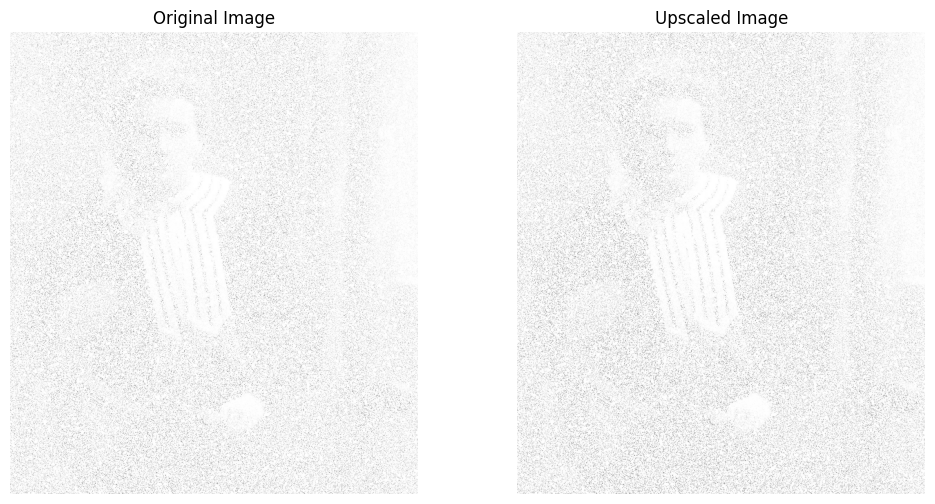


Choose Enhancement Method:
1 - Upscale Image
2 - Deblurring (Lucy-Richardson)
3 - Alternative Deblurring (Wiener)
4 - Sharpening (Laplacian)
5 - Noise Reduction
6 - Full Enhancement
Type 'exit' to quit.


Enter choice (1/2/3/4/5/6/exit):  2


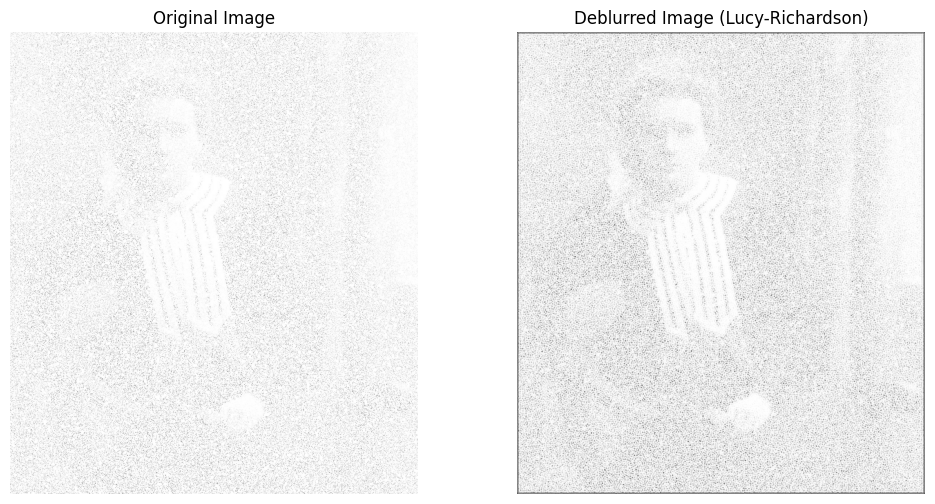


Choose Enhancement Method:
1 - Upscale Image
2 - Deblurring (Lucy-Richardson)
3 - Alternative Deblurring (Wiener)
4 - Sharpening (Laplacian)
5 - Noise Reduction
6 - Full Enhancement
Type 'exit' to quit.


Enter choice (1/2/3/4/5/6/exit):  3


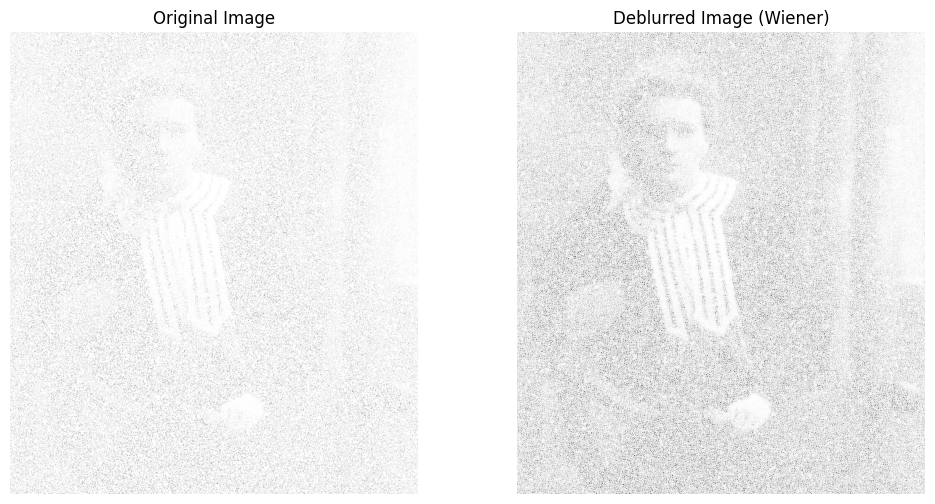


Choose Enhancement Method:
1 - Upscale Image
2 - Deblurring (Lucy-Richardson)
3 - Alternative Deblurring (Wiener)
4 - Sharpening (Laplacian)
5 - Noise Reduction
6 - Full Enhancement
Type 'exit' to quit.


Enter choice (1/2/3/4/5/6/exit):  6


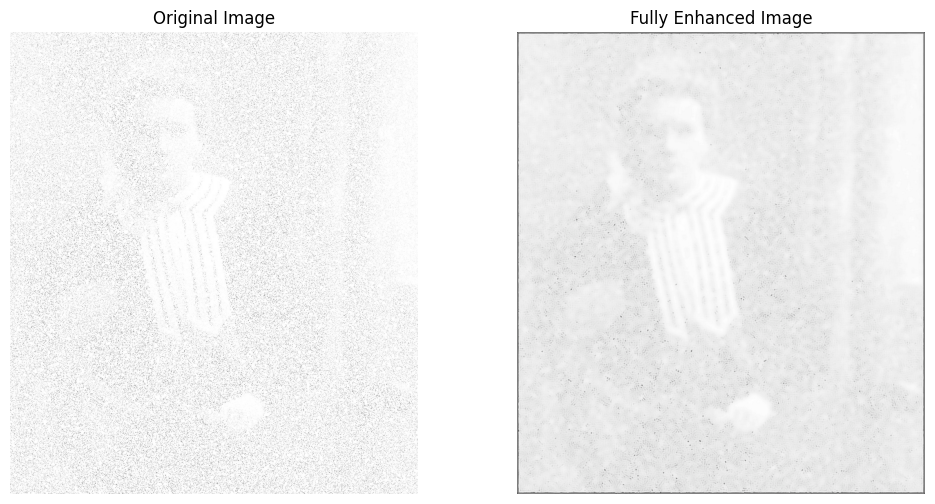


Choose Enhancement Method:
1 - Upscale Image
2 - Deblurring (Lucy-Richardson)
3 - Alternative Deblurring (Wiener)
4 - Sharpening (Laplacian)
5 - Noise Reduction
6 - Full Enhancement
Type 'exit' to quit.


Enter choice (1/2/3/4/5/6/exit):  exit


Exiting the program.


In [13]:
### import cv2
import numpy as np
from skimage import restoration, color
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog

# Create a Tkinter instance for file selection
root = tk.Tk()
root.withdraw()
image_path = filedialog.askopenfilename(
    title="Select an Image",
    filetypes=[("Image Files", "*.png;*.jpg;*.jpeg;*.bmp;*.tif;*.tiff")]
)
root.destroy()

if not image_path:
    print("No image selected! Exiting...")
    exit()

# Load and convert image
image = cv2.imread(image_path)
if image is None:
    print("Error: Failed to load the image.")
    exit()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def lucy_richardson_deblur_color(image, num_iter=20, kernel_size=7):
    r, g, b = cv2.split(image.astype(np.float64) / 255.0)
    x, y = np.mgrid[-kernel_size//2 + 1:kernel_size//2 + 1, -kernel_size//2 + 1:kernel_size//2 + 1]
    psf = np.exp(-(x**2 + y**2) / (2 * (kernel_size / 3)**2))
    psf /= psf.sum()
    return cv2.merge([
        np.clip(restoration.richardson_lucy(r, psf, num_iter) * 255, 0, 255).astype(np.uint8),
        np.clip(restoration.richardson_lucy(g, psf, num_iter) * 255, 0, 255).astype(np.uint8),
        np.clip(restoration.richardson_lucy(b, psf, num_iter) * 255, 0, 255).astype(np.uint8)
    ])

def wiener_deblur(image, kernel_size=5, noise_var=0.01):
    img_gray = color.rgb2gray(image.astype(np.float64) / 255.0)
    psf = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
    deblurred = restoration.wiener(img_gray, psf, noise_var)
    return np.clip(deblurred * 255, 0, 255).astype(np.uint8)

def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def denoise_image(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 15, 15, 7, 21)

def upscale_image(image, scale=2):
    return cv2.resize(image, (image.shape[1] * scale, image.shape[0] * scale), interpolation=cv2.INTER_CUBIC)

while True:
    print("\nChoose Enhancement Method:")
    print("1 - Upscale Image")
    print("2 - Deblurring (Lucy-Richardson)")
    print("3 - Alternative Deblurring (Wiener)")
    print("4 - Sharpening (Laplacian)")
    print("5 - Noise Reduction")
    print("6 - Full Enhancement")
    print("Type 'exit' to quit.")

    choice = input("Enter choice (1/2/3/4/5/6/exit): ").strip().lower()
    if choice == "exit":
        print("Exiting the program.")
        break
    
    if choice == "1":
        result = upscale_image(image)
        title = "Upscaled Image"
    elif choice == "2":
        result = lucy_richardson_deblur_color(image)
        title = "Deblurred Image (Lucy-Richardson)"
    elif choice == "3":
        result = wiener_deblur(image)
        title = "Deblurred Image (Wiener)"
    elif choice == "4":
        result = sharpen_image(image)
        title = "Sharpened Image (Laplacian)"
    elif choice == "5":
        result = denoise_image(image)
        title = "Noise Reduced Image"
    elif choice == "6":
        result = lucy_richardson_deblur_color(image)
        result = denoise_image(result)
        result = upscale_image(result)
        result = sharpen_image(result)
        title = "Fully Enhanced Image"
    else:
        print("Invalid choice! Try again.")
        continue

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(result, cmap='gray' if len(result.shape) == 2 else None)
    plt.title(title)
    plt.axis("off")

    plt.show()
